<a href="https://colab.research.google.com/github/rajp152k/Machine_Learning/blob/master/Deep%20Learning/Learning%20Pytorch/ImgClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### using the CIFAR10 dataset

loading and normalizing the dataset

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

creating a transformation sequence to be applied on the dataset

In [0]:
transformation_sequence = [transforms.ToTensor(),
                            transforms.Normalize(mean = [0.5,0.5,0.5],
                                                std = [0.5,0.5,0.5])]

transform  = transforms.Compose(transformation_sequence)

getting the dataset 

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data',train=True,
                                       download=True,transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,batch_size=4,shuffle=True
                                         ,num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data',train=False,
                                       download=True,transform=transform)

testloader = torch.utils.data.DataLoader(testset,batch_size=4,shuffle=False
                                        ,num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


checking some of the images in the dataset

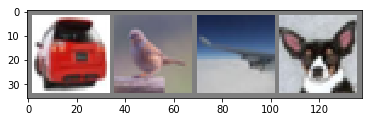

  car  bird plane   dog


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img/2 +0.5 #denormalizing
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()
    
# collecting some images
dataiter = iter(trainloader)
images,labels = dataiter.next()

# showing them
imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]]for j in range(4)))

### size of input image

In [5]:
images[0][0].size()

torch.Size([32, 32])

### defining the net now

In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self,x):
              
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
        

In [0]:
net = Net()

### Defining loss function and optimizer

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() #cross entropy performs 
                                  #better for classification than MSE 

optimizer  = optim.SGD(params = net.parameters(),lr = 0.001,momentum = 0.9)


 ## *Read about Nesterov Momentum*
 before advancing

Training the network

In [14]:
for epoch in range(2):
    
    running_loss = 0.0
    for i,data in enumerate(trainloader,0):
        
        inputs,labels = data
        
        optimizer.zero_grad() #nullifying gradient buffers
        
        outputs = net(inputs)
        
        loss = criterion(outputs,labels) #computing loss
        
        loss.backward() # back propogation (only storing gradients now)
        
        optimizer.step() # back propogation completion (updating the weights)
        
        #printing live statistics
        
        running_loss += loss.item()
        
        if i%2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
print("NET TRAINED")

[1,  2000] loss: 2.172
[1,  4000] loss: 1.838
[1,  6000] loss: 1.636
[1,  8000] loss: 1.556
[1, 10000] loss: 1.510
[1, 12000] loss: 1.460
[2,  2000] loss: 1.408
[2,  4000] loss: 1.361
[2,  6000] loss: 1.355
[2,  8000] loss: 1.309
[2, 10000] loss: 1.297
[2, 12000] loss: 1.281
NET TRAINED


### testing the network

In [0]:
checking some images from the test set first

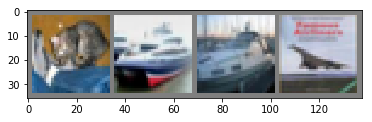

GroundTruth:    cat  ship  ship plane


In [18]:
dataiter = iter(testloader)
images,labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ',' '.join('%5s' % classes[labels[j]] for j in range(4)))


checking above images from the neural network

In [0]:
outputs = net(images)



In [23]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


satisfactory results

now checking the network on the whole dataset

In [25]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images,labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images : %d %%' % (100*correct/total))

Accuracy of the network on the 10000 test images : 52 %


good enough for a classification into 10 classes

In [0]:
class_correct = [0]*10
class_total = [0]*10

In [31]:
with torch.no_grad():
    for data in testloader:
        images,labels = data
        outputs = net(images)
        _,predicted = torch.max(outputs,1)
        c = (predicted==labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    print("accuracy of %5s : %2d %%" % (classes[i],100*class_correct[i]/class_total[i]))

accuracy of plane : 54 %
accuracy of   car : 49 %
accuracy of  bird : 53 %
accuracy of   cat : 30 %
accuracy of  deer : 39 %
accuracy of   dog : 44 %
accuracy of  frog : 75 %
accuracy of horse : 57 %
accuracy of  ship : 72 %
accuracy of truck : 52 %


## using GPU 

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")
print(device)

cuda:0


In [40]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)